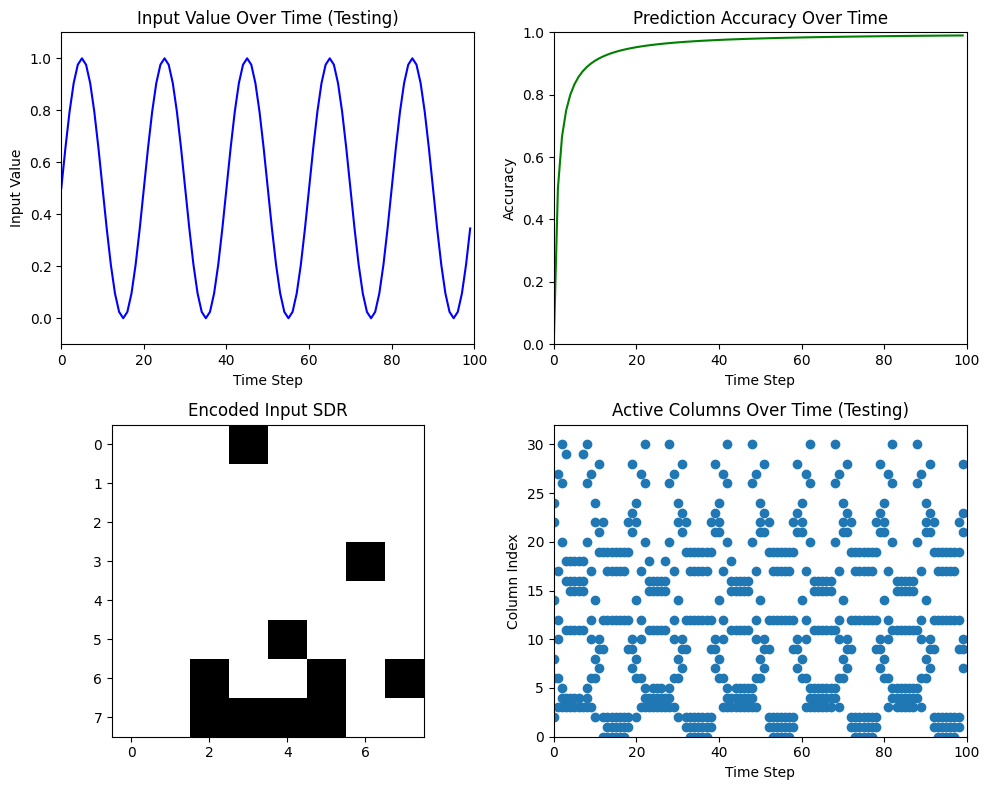

/home/u1/Envs/Python/darts/venv/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [5]:
"""
Hierarchical Temporal Memory (HTM) Model Implementation with Animation
-----------------------------------------------------------------------

This Python program implements a simple Hierarchical Temporal Memory (HTM) model
from scratch and includes animation using matplotlib. The goal is to provide
an educational tool that demonstrates how each part of the HTM model works under the hood,
and to visualize the model's behavior over time through animation.

The model includes:
- A Randomly Distributed Scalar Encoder (RDSE)
- A Spatial Pooler (SP)
- A Temporal Memory (TM)

Visualization includes:
- Animating the input values over time
- Visualizing the Sparse Distributed Representations (SDRs)
- Animating the active columns in the Spatial Pooler
- Displaying the prediction accuracy over time

Each component is thoroughly commented to explain the underlying concepts and mechanics.
"""

import random
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

# Step 1: Basic Setup and Initialization
# --------------------------------------

# Define the range of scalar values we will encode (e.g., floats from 0.0 to 1.0)
MIN_INPUT_VALUE = 0.0
MAX_INPUT_VALUE = 1.0

# Define the size of the encoder's output vector (number of bits)
ENCODER_OUTPUT_SIZE = 64  # Should be a perfect square for visualization purposes

# Define the number of bits that will be active in the encoder's output
NUM_ACTIVE_BITS = 10

# Define the resolution of the encoder (how precisely it can represent input values)
ENCODER_RESOLUTION = 0.01

# Define the number of columns in the Spatial Pooler
NUM_SP_COLUMNS = 32

# Define the percentage of columns that can be active after inhibition in the SP
SP_ACTIVE_PERCENTAGE = 0.2  # 20% of columns can be active

# Define the number of cells per column in the Temporal Memory
TM_CELLS_PER_COLUMN = 4

# Define the number of iterations (time steps) to run the model
NUM_ITERATIONS = 100

# Generate a simple data sequence (e.g., a sine wave)
input_sequence = [0.5 + 0.5 * math.sin(2 * math.pi * t / 20) for t in range(NUM_ITERATIONS)]

# Split the data into training and testing sets
split_ratio = 0.7
split_index = int(NUM_ITERATIONS * split_ratio)
train_sequence = input_sequence[:split_index]
test_sequence = input_sequence[split_index:]

# Step 2: Randomly Distributed Scalar Encoder (RDSE)
# --------------------------------------------------

class RandomDistributedScalarEncoder:
    """
    This encoder takes scalar values and converts them into sparse binary representations.
    It uses a set of random prototypes (random numbers within the input range).
    Each prototype corresponds to a bit in the output SDR.
    To encode a value, we find the prototypes closest to the input value.
    The indices of these prototypes are the active bits in the SDR.
    """

    def __init__(self, min_value, max_value, output_size, num_active_bits, resolution, seed=None):
        """
        Initialize the RDSE with the specified parameters.

        Args:
            min_value (float): The minimum scalar value to encode.
            max_value (float): The maximum scalar value to encode.
            output_size (int): The size of the output binary vector (number of bits).
            num_active_bits (int): The number of bits that will be active in the output.
            resolution (float): The resolution of the encoder.
            seed (int, optional): Seed for random number generator.
        """
        self.min_value = min_value
        self.max_value = max_value
        self.output_size = output_size
        self.num_active_bits = num_active_bits
        self.resolution = resolution
        if seed is not None:
            random.seed(seed)

        # Generate random prototypes within the input range
        self.prototypes = [random.uniform(self.min_value, self.max_value) for _ in range(self.output_size)]

    def encode(self, value):
        """
        Encode a scalar value into its sparse binary representation.

        Args:
            value (float): The scalar value to encode.

        Returns:
            list: The binary vector representation of the input value.
        """
        # Compute distances between the input value and each prototype
        distances = [(i, abs(value - prototype)) for i, prototype in enumerate(self.prototypes)]
        # Sort prototypes by distance to the input value
        sorted_distances = sorted(distances, key=lambda x: x[1])
        # Select indices of the prototypes with the smallest distances
        active_indices = [index for index, _ in sorted_distances[:self.num_active_bits]]
        # Create the SDR with active bits at the selected indices
        sdr = [1 if i in active_indices else 0 for i in range(self.output_size)]
        return sdr

# Step 3: Spatial Pooler (SP) Implementation
# ------------------------------------------

class SpatialPooler:
    """
    The Spatial Pooler converts sparse input into a stable representation by learning which input patterns
    frequently co-occur. It selects a subset of columns to be active based on the overlap with the input
    and applies inhibition to ensure sparsity.
    """

    def __init__(self, input_size, num_columns, active_percentage):
        """
        Initialize the Spatial Pooler with the specified parameters.

        Args:
            input_size (int): The size of the input vector from the encoder.
            num_columns (int): The number of columns in the Spatial Pooler.
            active_percentage (float): The percentage of columns that can be active after inhibition.
        """
        self.input_size = input_size
        self.num_columns = num_columns
        self.active_percentage = active_percentage

        # Initialize potential synapses for each column
        # Each column is connected to a random subset of the input bits
        self.potential_synapses = {}
        self.permanences = {}
        self.connected_synapses = {}
        for col in range(self.num_columns):
            # Each column is connected to a random subset of the input bits
            potential = random.sample(range(self.input_size), int(0.5 * self.input_size))
            self.potential_synapses[col] = potential
            # Permanences determine the strength of the synapses
            self.permanences[col] = {i: random.uniform(0.0, 1.0) for i in potential}
            # A synapse is connected if its permanence is above a threshold (e.g., 0.2)
            self.connected_synapses[col] = [i for i in potential if self.permanences[col][i] >= 0.2]

    def compute_overlap(self, input_vector):
        """
        Compute the overlap between the input vector and the connected synapses for each column.

        Args:
            input_vector (list): The binary vector from the encoder.

        Returns:
            dict: A mapping from column index to overlap score.
        """
        overlaps = {}
        for col in range(self.num_columns):
            # Count the number of connected synapses that are active
            overlap = sum([input_vector[i] for i in self.connected_synapses[col]])
            overlaps[col] = overlap
        return overlaps

    def inhibit_columns(self, overlaps):
        """
        Apply inhibition to select a subset of columns to be active based on their overlap scores.

        Args:
            overlaps (dict): A mapping from column index to overlap score.

        Returns:
            list: Indices of the active columns after inhibition.
        """
        # Determine the number of columns that can be active
        num_active_columns = max(1, int(self.num_columns * self.active_percentage))
        # Sort columns by overlap score in descending order
        sorted_columns = sorted(overlaps.items(), key=lambda item: item[1], reverse=True)
        # Select the top columns based on overlap score
        active_columns = [col for col, overlap in sorted_columns[:num_active_columns] if overlap > 0]
        return active_columns

    def update_permanences(self, active_columns, input_vector):
        """
        Update the permanences of the synapses based on the current input and active columns.

        Args:
            active_columns (list): Indices of the active columns after inhibition.
            input_vector (list): The binary vector from the encoder.
        """
        for col in active_columns:
            for i in self.potential_synapses[col]:
                # Increase permanence if the input bit is active, else decrease it
                if input_vector[i] == 1:
                    self.permanences[col][i] = min(1.0, self.permanences[col][i] + 0.05)
                else:
                    self.permanences[col][i] = max(0.0, self.permanences[col][i] - 0.02)
            # Update the list of connected synapses based on permanence threshold
            self.connected_synapses[col] = [i for i in self.potential_synapses[col] if self.permanences[col][i] >= 0.2]

# Step 4: Temporal Memory (TM) Initialization
# -------------------------------------------

class TemporalMemory:
    """
    The Temporal Memory learns sequences of spatial patterns and predicts future inputs based on past patterns.
    It models temporal relationships by connecting cells within and across columns.
    """

    def __init__(self, num_columns, cells_per_column):
        """
        Initialize the Temporal Memory with the specified parameters.

        Args:
            num_columns (int): The number of columns from the Spatial Pooler.
            cells_per_column (int): The number of cells per column.
        """
        self.num_columns = num_columns
        self.cells_per_column = cells_per_column

        # Initialize cell states
        # Each cell can be in an active state or predictive state
        self.active_cells = set()
        self.predictive_cells = set()
        self.previous_active_cells = set()

        # Initialize segment connections between cells
        # For simplicity, we model segments as direct connections between cells
        self.segment_connections = {}  # Key: cell index, Value: set of connected cell indices

    def column_cells(self, col_idx):
        """
        Get the indices of all cells in a given column.

        Args:
            col_idx (int): The index of the column.

        Returns:
            list: Indices of the cells in the column.
        """
        return [col_idx * self.cells_per_column + i for i in range(self.cells_per_column)]

    def activate_cells(self, active_columns):
        """
        Determine which cells become active based on the active columns and predictive cells.

        Args:
            active_columns (list): Indices of the active columns from the Spatial Pooler.
        """
        new_active_cells = set()
        for col in active_columns:
            # Get the cells in the column
            cells = self.column_cells(col)
            # Find predictive cells in the column
            predictive_in_column = self.predictive_cells.intersection(cells)
            if predictive_in_column:
                # If there are predictive cells, make them active
                new_active_cells.update(predictive_in_column)
            else:
                # If no predictive cells, activate all cells (bursting)
                new_active_cells.update(cells)
        self.active_cells = new_active_cells

    def predict_cells(self):
        """
        Update the predictive cells based on the current active cells.
        """
        new_predictive_cells = set()
        for cell in self.active_cells:
            # Cells that this cell predicts (cells that are connected via segments)
            predicted_cells = self.segment_connections.get(cell, set())
            new_predictive_cells.update(predicted_cells)
        self.predictive_cells = new_predictive_cells

    def learn_sequences(self):
        """
        Learn sequences by reinforcing connections between currently active cells and previously active cells.
        """
        for cell in self.active_cells:
            # For each previously active cell, create or reinforce a connection to the current cell
            for prev_cell in self.previous_active_cells:
                # Create or reinforce connection from prev_cell to cell
                if prev_cell not in self.segment_connections:
                    self.segment_connections[prev_cell] = set()
                self.segment_connections[prev_cell].add(cell)

    def update_state(self):
        """
        Update the state for the next time step.
        """
        self.previous_active_cells = self.active_cells.copy()
        self.predict_cells()

# Step 5: Feeding Input Data and Processing with Animation
# --------------------------------------------------------

def main():
    # Initialize the components
    encoder = RandomDistributedScalarEncoder(
        min_value=MIN_INPUT_VALUE,
        max_value=MAX_INPUT_VALUE,
        output_size=ENCODER_OUTPUT_SIZE,
        num_active_bits=NUM_ACTIVE_BITS,
        resolution=ENCODER_RESOLUTION,
        seed=None  # Optional, set a seed for reproducibility
    )

    spatial_pooler = SpatialPooler(
        input_size=ENCODER_OUTPUT_SIZE,
        num_columns=NUM_SP_COLUMNS,
        active_percentage=SP_ACTIVE_PERCENTAGE
    )

    temporal_memory = TemporalMemory(
        num_columns=NUM_SP_COLUMNS,
        cells_per_column=TM_CELLS_PER_COLUMN
    )

    # Initialize variables to track prediction accuracy and history
    correct_predictions = []
    time_steps = []
    prediction_results = []
    active_columns_history = []
    input_values = []
    encoded_inputs = []
    predicted_columns_history = []
    expected_active_columns_history = []
    accuracy_over_time = []

    # Helper function to visualize SDRs
    def sdr_to_matrix(sdr):
        n = int(math.sqrt(len(sdr)))
        sdr_matrix = np.reshape(sdr, (n, n))
        return sdr_matrix

    # Prepare for animation
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Initialize plots
    input_line, = axes[0, 0].plot([], [], 'b-')
    axes[0, 0].set_xlim(0, NUM_ITERATIONS)
    axes[0, 0].set_ylim(MIN_INPUT_VALUE - 0.1, MAX_INPUT_VALUE + 0.1)
    axes[0, 0].set_title('Input Value Over Time')
    axes[0, 0].set_xlabel('Time Step')
    axes[0, 0].set_ylabel('Input Value')

    accuracy_line, = axes[0, 1].plot([], [], 'g-')
    axes[0, 1].set_xlim(0, NUM_ITERATIONS)
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_title('Prediction Accuracy Over Time')
    axes[0, 1].set_xlabel('Time Step')
    axes[0, 1].set_ylabel('Accuracy')

    sdr_image = axes[1, 0].imshow(np.zeros((int(math.sqrt(ENCODER_OUTPUT_SIZE)), int(math.sqrt(ENCODER_OUTPUT_SIZE)))), cmap='binary', vmin=0, vmax=1)
    axes[1, 0].set_title('Encoded Input SDR')

    active_columns_scatter = axes[1, 1].scatter([], [])
    axes[1, 1].set_xlim(0, NUM_ITERATIONS)
    axes[1, 1].set_ylim(0, NUM_SP_COLUMNS)
    axes[1, 1].set_title('Active Columns Over Time')
    axes[1, 1].set_xlabel('Time Step')
    axes[1, 1].set_ylabel('Column Index')

    plt.tight_layout()

    def init():
        input_line.set_data([], [])
        accuracy_line.set_data([], [])
        sdr_image.set_data(np.zeros((int(math.sqrt(ENCODER_OUTPUT_SIZE)), int(math.sqrt(ENCODER_OUTPUT_SIZE)))))
        # Corrected line: Pass an empty array with shape (0, 2)
        active_columns_scatter.set_offsets(np.empty((0, 2)))
        return input_line, accuracy_line, sdr_image, active_columns_scatter

    def animate(t):
        # Training phase
        if t < len(train_sequence):
            input_value = train_sequence[t]
            phase = 'Training'
        else:
            # Testing phase
            input_value = test_sequence[t - len(train_sequence)]
            phase = 'Testing'

        # Encode the input value
        encoded_input = encoder.encode(input_value)
        encoded_inputs.append(encoded_input)
        input_values.append(input_value)

        # Spatial Pooler computes overlap and selects active columns
        overlaps = spatial_pooler.compute_overlap(encoded_input)
        active_columns = spatial_pooler.inhibit_columns(overlaps)
        active_columns_history.append((t, active_columns))

        # Update SP permanences during training
        if phase == 'Training':
            spatial_pooler.update_permanences(active_columns, encoded_input)

        # Temporal Memory activates cells and predicts next inputs
        temporal_memory.activate_cells(active_columns)
        if phase == 'Training':
            temporal_memory.learn_sequences()
        temporal_memory.update_state()

        # Prediction
        if t < NUM_ITERATIONS - 1:
            if phase == 'Training':
                next_input_value = train_sequence[t + 1] if t + 1 < len(train_sequence) else test_sequence[0]
            else:
                next_input_value = test_sequence[t - len(train_sequence) + 1] if t - len(train_sequence) + 1 < len(test_sequence) else test_sequence[0]

            next_encoded_input = encoder.encode(next_input_value)
            next_overlaps = spatial_pooler.compute_overlap(next_encoded_input)
            expected_active_columns = spatial_pooler.inhibit_columns(next_overlaps)
            expected_active_columns_history.append((t + 1, expected_active_columns))

            # Predicted columns from the Temporal Memory
            predicted_columns = set()
            for cell in temporal_memory.predictive_cells:
                col = cell // TM_CELLS_PER_COLUMN
                predicted_columns.add(col)
            predicted_columns_history.append((t + 1, predicted_columns))

            # Check if any of the expected columns are in the predicted columns
            if any(col in predicted_columns for col in expected_active_columns):
                correct_predictions.append(1)
            else:
                correct_predictions.append(0)

            # Update accuracy over time
            accuracy = sum(correct_predictions) / len(correct_predictions)
            accuracy_over_time.append(accuracy)
        else:
            accuracy_over_time.append(accuracy_over_time[-1] if accuracy_over_time else 0)

        time_steps.append(t)

        # Update plots
        input_line.set_data(time_steps, input_values)
        accuracy_line.set_data(time_steps, accuracy_over_time)

        # Update SDR image
        sdr_matrix = sdr_to_matrix(encoded_input)
        sdr_image.set_data(sdr_matrix)

        # Update active columns scatter plot
        x_data = []
        y_data = []
        for time_step, cols in active_columns_history:
            x_data.extend([time_step] * len(cols))
            y_data.extend(cols)
        # Ensure that x_data and y_data are not empty
        if x_data and y_data:
            active_columns_scatter.set_offsets(np.column_stack((x_data, y_data)))
        else:
            active_columns_scatter.set_offsets(np.empty((0, 2)))

        axes[0, 0].set_title(f'Input Value Over Time ({phase})')
        axes[1, 1].set_title(f'Active Columns Over Time ({phase})')

        return input_line, accuracy_line, sdr_image, active_columns_scatter

    # Create animation
    ani = animation.FuncAnimation(fig, animate, frames=NUM_ITERATIONS, init_func=init, blit=False, interval=100, repeat=False)

    # Save animation to video file
    ani.save('htm_animation.mp4', writer='ffmpeg', fps=10)

    # Show the animation
    plt.show()

    # Keep the animation object alive until after plt.show()
    return ani

if __name__ == "__main__":
    ani = main()
    # The variable 'ani' is kept alive until this point
